In [5]:
# importing the required libraries
library(keras)
library(abind)
library(grid)

In [6]:
# loading the data and reshaping it
mnist <- dataset_fashion_mnist()
x_train <- mnist$train$x/255
x_test <- mnist$test$x/255
x_train <- array_reshape(x_train, c(nrow(x_train), 784), order = "F")
x_test <- array_reshape(x_test, c(nrow(x_test), 784), order = "F")

In [7]:
# defining the network parameters
batch_size <- 100L
input_dim <- 784L
latent_dim <- 2L
epochs <- 10

In [8]:
# input layer and hidden layer of the encoder part of the VAE
input <- layer_input(shape = c(input_dim))
x <- input %>% layer_dense(units =  256, activation = "relu")

In [9]:
# defining dense layers repesenting mean and log of standard deviation of the latent distribution

# mean of  latent distribution
z_mean <-  x %>% layer_dense(units =  latent_dim,name = "mean")

# log variance of  latent distribution
z_log_sigma <- x %>% layer_dense(units =  latent_dim,name = "sigma")

In [10]:
# sampling function to sample points from latent space
sampling <- function(arg) {
    z_mean <- arg[, 1:(latent_dim)]
    z_log_var <- arg[, (latent_dim + 1):(2 * latent_dim)]
    epsilon <- k_random_normal(shape = list(k_shape(z_mean)[1], latent_dim),
                               mean = 0, stddev = 1)
    z_mean + k_exp(z_log_sigma) * epsilon
}

In [11]:
# generating a random point from the latent distributiom
z <- layer_concatenate(list(z_mean, z_log_sigma)) %>% layer_lambda(sampling)

In [12]:
# hidden layers of the decoder part of VAE
x_1 <- layer_dense(units = 256, activation = "relu") 
x_2 <- layer_dense(units = input_dim, activation = "sigmoid")

# decoder output
vae_output <- x_2(x_1(z))

In [9]:
# building the variational autoencoder model
vae <- keras_model(input, vae_output)
summary(vae)

________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_1 (InputLayer)      (None, 784)       0                                   
________________________________________________________________________________
dense (Dense)             (None, 256)       200960   input_1[0][0]              
________________________________________________________________________________
mean (Dense)              (None, 2)         514      dense[0][0]                
________________________________________________________________________________
sigma (Dense)             (None, 2)         514      dense[0][0]                
________________________________________________________________________________
concatenate (Concatenate) (None, 4)         0        mean[0][0]                 
                                                     sigma[0][0]                
____________________________

In [10]:
# building separate encoder model that maps inputs to latent space

encoder <- keras_model(input, c(z_mean,z_log_sigma))
summary(encoder)

________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_1 (InputLayer)      (None, 784)       0                                   
________________________________________________________________________________
dense (Dense)             (None, 256)       200960   input_1[0][0]              
________________________________________________________________________________
mean (Dense)              (None, 2)         514      dense[0][0]                
________________________________________________________________________________
sigma (Dense)             (None, 2)         514      dense[0][0]                
Total params: 201,988
Trainable params: 201,988
Non-trainable params: 0
________________________________________________________________________________


In [13]:
# building separate decoder model

# Decoder input
decoder_input <- layer_input(k_int_shape(z)[-1])

# Decoder hidden layers
decoder_output <- x_2(x_1(decoder_input)) 
# Decoder
decoder <- keras_model(decoder_input,decoder_output)

summary(decoder)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_2 (InputLayer)                (None, 2)                       0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 256)                     768         
________________________________________________________________________________
dense_2 (Dense)                     (None, 784)                     201488      
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
________________________________________________________________________________


In [48]:
# defining loss function
vae_loss <- function(x, decoded_output){
  reconstruction_loss <- (input_dim/1.0)*loss_binary_crossentropy(x, decoded_output)
  kl_loss <- -0.5*k_mean(1 + z_log_sigma - k_square(z_mean) - k_exp(z_log_sigma), axis = -1L)
  reconstruction_loss + kl_loss
}


In [49]:
# compiling the model
vae %>% compile(optimizer = "rmsprop", loss = vae_loss)

In [50]:
# training the model
vae %>% fit(
  x_train, x_train, 
  shuffle = TRUE, 
  epochs = epochs, 
  batch_size = batch_size, 
  validation_data = list(x_test, x_test)
)

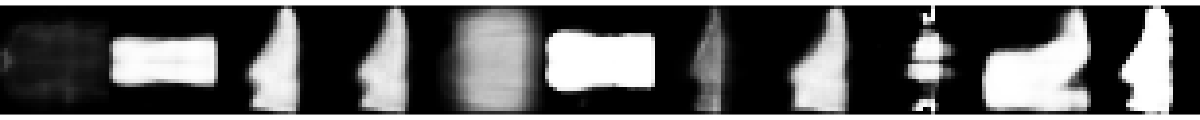

In [51]:
# generating sample images

random_distribution = array(rnorm(n = 20,mean = 0,sd = 4),dim = c(10,2))

predicted = array_reshape(predict(decoder,matrix(c(0,0),ncol=2)),dim = c(28,28))

for(i in seq(1,nrow(random_distribution))){
    one_pred = predict(decoder,matrix(random_distribution[i,],ncol=2))  
    predicted = abind(predicted,array_reshape(one_pred,dim = c(28,28)),along = 2)
}

options(repr.plot.width=10, repr.plot.height=1)

grid.raster(predicted,interpolate=FALSE)